# Introduction and Problem Statement

Wave forecasting for the sport of surfing is an exercise thats been going on since the sport's creation. It is a common occurence for surfers to try and predict wave surfability in the future from present and histroical conditions. In fact, there are companies dedicated to the purpose of forecasting waves for surfers that rely on user subscriptions to gain revenue.

Additionally, there is a wealth of free data available, on present and historical surf conditions, provided by NOAA via the National Data Buoy Center. So, the question that arises is: Is there a way to apply deep learning methodology to this freely available data, to create a reliable wave forecasting tool?

Neural Networks, such as CNN and RNN are often used in image classification and text classification use cases, but there are additional novel uses for CNN and RNN with time-series data. This use of sequencing allows one to utilize CNN and RNN models to analysze this data. This project uses LSTMs (vanilla LSTMs and Bidirectional LSTMs) as well as 1D CNN models for frorecasting time series data (by way of regression and classification).

**This project will attempt to apply RNN and CNN models to time series data collected by NOAA Buoys and use this data to forecast surf conditions 24 hours ahead of the present moment in time.** The surf conditions that will be predicted are:

A) Surf Score: feature engineered metric created to represent physical surf conditions (wave height, period, and wind speed) converted into a 0-10 scale.

and

B) Surf Label, a.k.a. "surfability":  A binary classification of whether not the present surf conditions are surfable or not (also feature engineered from domain knowledge of physical surf conditions)

These target metrics will be predicted by six separate models. The surf score will be predicted via regression modeling, and the surfability will be predicted via binary classification modeling.

In fact, a related work has been done using LSTMs to predict ocean wave conditions. Minuzzi and Farina (2023) used time series buoy data on a select number of buoys off of the Brazilian coast to try and predict a significant wave height change via LSTMs

Unlike the study mentioned though, this project will attempt to understand overall wave conditions as it relates to surfing given time series buoy data via the feature engineered metrics of surf score and surf label (surfability). Additionally, this project will use all of the buoys within the NOAA NBDC network, and will apply CNNs and BiLSTMs to this data rather than simply LSTMs.



The six separate models that will be created in this project are:

1A. Vanilla LSTM Regression Model

1B. Vanilla LSTM Classification Model

2A. 1D CNN Regression Model

2B. 1D CNN Classificatioon Model

3A. Bidirectional LSTM Regression Model with Hyperparameter tuning

3B. Bidirectional LSTM Classification Model with Hyperparameter tuning

*A Note on runtime: If you are planning on running this notebook to replicate the results, it is suggested to use a T4 GPU (or similar GPU spec) with HIGH-RAM. Using lower ram specs will result in kernel crashing.*

# A Note on the Data Source and Data Engineering

The data used in this project comes from NOOA NBDC data. It is all pulled from https://www.ndbc.noaa.gov/data/historical/stdmet/ . This web page is a repository of all historical buoy information currently available. The data is spread across various .txt files and zipped (one file per buoy).

Great lengths were taken to pull all this data into one file to load into this notebook. To help improve overall notebook readability, the details of how this data was pulled together is in the Appendix section under "data engineering".

This appendix shows how the data was combined and saved into a single file (in parquet form for compression and speed). The final parquet file is 448 MB large, and contains only the necesary features required for wave forecasting. As one can see below, the data load and ingestion pulls this file directly into this notebook.

**The data that is loaded into the EDA section below is 33.3 million rows long with 25 total features.** Some of the features will be dropped prior to modeling, and a final description of the model dataframe, including a description of the final features passed to the models, will be provided within the EDA section

Data Citation (also in Citation section at bottom of notebook):

National Data Buoy Center. (1971–2025). Standard Meteorological (stdmet) historical buoy data. NOAA.https://www.ndbc.noaa.gov/data/historical/stdmet/




## Library Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from datetime import datetime
import xml.etree.ElementTree as ET
from tqdm import tqdm
import requests
import gzip
from io import StringIO
import gc
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import re
import IPython.display as display
from matplotlib.colors import ListedColormap

# EDA

## Data Load and Ingestion



Initially loading the data in from google drive and displaying the data head

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_parquet('/content/drive/MyDrive/dl_Final/bouy_data.parquet')
df.head()

,YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,...,DEWP,VIS,TIDE,datetime,bouy_id,name,lat,lon,owner,type
0,2019,5,1,18,40,76.0,0.1,1.2,NaN,NaN,...,18.1,NaN,NaN,2019-05-01 18:40:00,41001,EAST HATTERAS - 150 NM East of Cape Hatteras,34.791,-72.42,NDBC,other
1,2019,5,1,18,50,57.0,0.1,0.8,NaN,NaN,...,18.1,NaN,NaN,2019-05-01 18:50:00,41001,EAST HATTERAS - 150 NM East of Cape Hatteras,34.791,-72.42,NDBC,other
2,2019,5,1,19,0,65.0,0.1,1.2,NaN,NaN,...,18.2,NaN,NaN,2019-05-01 19:00:00,41001,EAST HATTERAS - 150 NM East of Cape Hatteras,34.791,-72.42,NDBC,other
3,2019,5,1,19,10,69.0,0.1,0.7,NaN,NaN,...,18.3,NaN,NaN,2019-05-01 19:10:00,41001,EAST HATTERAS - 150 NM East of Cape Hatteras,34.791,-72.42,NDBC,other
4,2019,5,1,19,20,64.0,0.1,1.3,NaN,NaN,...,18.3,NaN,NaN,2019-05-01 19:20:00,41001,EAST HATTERAS - 150 NM East of Cape Hatteras,34.791,-72.42,NDBC,other


## Data Inspection

As mentioned previously, the initial dataset is 33 million rows with 25 total features. The below codeblock displays the dtype and column name for all 25 columns in the dataset. The relevant columns that will be kept will be described further down, but as one can see they show the relevant time features as well as physical measurements collected by the buoy (wind direction, wind speed, wave height, etc)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33543574 entries, 0 to 33543573
Data columns (total 25 columns):
 #   Column    Dtype         
---  ------    -----         
 0   YY        int64         
 1   MM        int64         
 2   DD        int64         
 3   hh        int64         
 4   mm        int64         
 5   WDIR      float64       
 6   WSPD      float64       
 7   GST       float64       
 8   WVHT      float64       
 9   DPD       float64       
 10  APD       float64       
 11  MWD       float64       
 12  PRES      float64       
 13  ATMP      float64       
 14  WTMP      float64       
 15  DEWP      float64       
 16  VIS       float64       
 17  TIDE      float64       
 18  datetime  datetime64[ns]
 19  bouy_id   object        
 20  name      object        
 21  lat       object        
 22  lon       object        
 23  owner     object        
 24  type      object        
dtypes: datetime64[ns](1), float64(13), int64(5), object(6)
memory usage: 6

The below block takes the lattitude and longitude features, and forces them to numeric, as they were stored as dtype-object.

Additionally, the features that are not relevant for this modeling exercise are dropped. The remaining features are:

WSPD- Windspeed captured by the Buoy, measured in in meters/second

WVHT- Waveheight captured by the buoy, measured in meters

DPD- Dominant Period captured by the buoy, measured in seconds.

AVD- Average Wave Period captured by the buoy, measured in seconds.

datetime - The time at which the measurement was captured

bouy-id- Unique id representing the buoy measuring the data

lat- Latitude coordinate of buoy

lon- Longitude coordinate of buoy


In [5]:
df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
df['lon'] = pd.to_numeric(df['lon'], errors='coerce')

df = df.drop(columns = ['YY', 'MM', 'DD', 'hh', 'mm', 'DEWP', 'VIS', 'TIDE', 'GST', 'PRES',
                        'ATMP', 'WTMP', 'name', 'owner', 'type', 'WDIR', 'MWD'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33543574 entries, 0 to 33543573
Data columns (total 8 columns):
 #   Column    Dtype         
---  ------    -----         
 0   WSPD      float64       
 1   WVHT      float64       
 2   DPD       float64       
 3   APD       float64       
 4   datetime  datetime64[ns]
 5   bouy_id   object        
 6   lat       float64       
 7   lon       float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 2.0+ GB


In [6]:
df.shape

(33543574, 8)

In [7]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
WSPD,25969005.0,5.87676,0.0,3.6,5.6,7.8,34.3,3.069975
WVHT,15176558.0,1.245595,0.0,0.54,1.0,1.68,20.0,1.000913
DPD,14633497.0,8.398929,0.0,4.76,8.33,11.43,3551.0,4.75797
APD,11694233.0,6.063274,1.47,4.74,5.9,7.18,23.53,1.889728
datetime,33543574,2022-04-07 22:38:11.072854784,2018-12-31 23:50:00,2020-10-19 16:30:00,2022-06-05 03:20:00,2023-09-24 06:40:00,2024-12-31 23:56:00,NaN
lat,33543574.0,35.374944,-14.296,27.908,36.001,42.135,60.802,10.729286
lon,33543574.0,-97.458587,-177.468,-123.317,-87.548,-75.722,179.764,41.029572


## General Visualizations

The below visuals show the distribution of wave height, wave period, and wind speed across a sampled portion of the dataset. This allows one to see the frequency of different values across the dataset. As one can see, the wave height, period, and wind speed are all relatively right skewed, with a peak in smaller values, tailing off into the larger ones. This is to be expected, becuase on average, most waves across the U.S. are on the smaller side, and there are only a few periods of time during the year where they are larger.

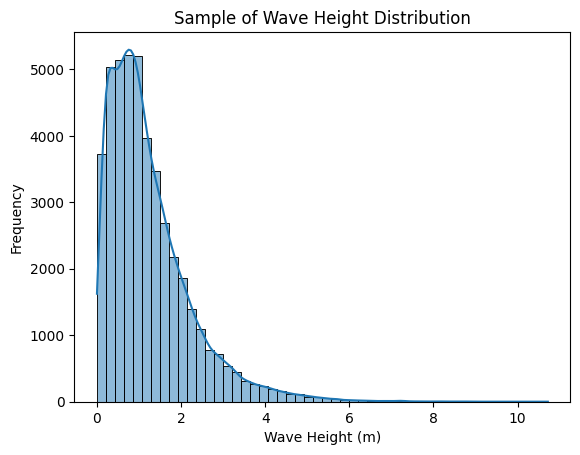

In [8]:
sample = df.sample(100000, random_state =42)
plt.figure()
sns.histplot(sample['WVHT'], bins = 50, kde = True)
plt.title('Sample of Wave Height Distribution')
plt.xlabel('Wave Height (m)')
plt.ylabel('Frequency')
plt.show()

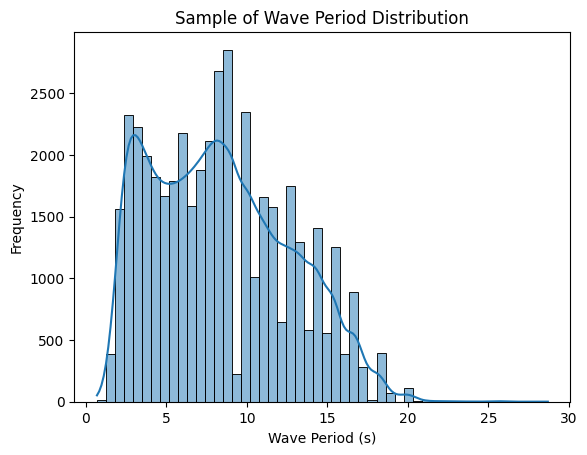

In [9]:
sns.histplot(sample['DPD'], bins = 50, kde = True)
plt.title('Sample of Wave Period Distribution')
plt.xlabel('Wave Period (s)')
plt.ylabel('Frequency')
plt.show()

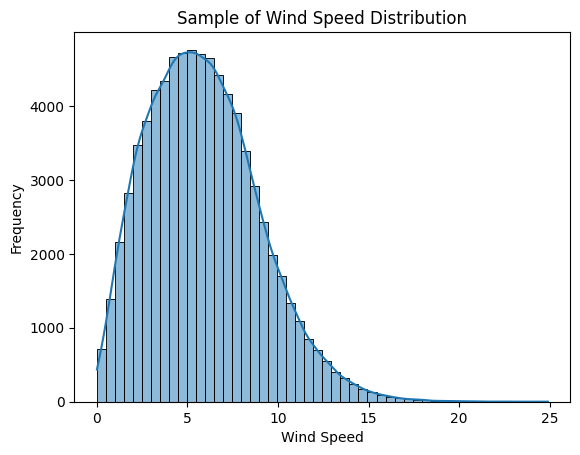

In [10]:
sns.histplot(sample['WSPD'], bins = 50, kde = True)
plt.title('Sample of Wind Speed Distribution')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.show()

The below visual is a correlation heatmap between the features wave height, dominant period, average period, and windspeed. As one can see, most of these feature have some sort of correlation with one of the others (with the exception of period and windspeed). This makes intuitive sense, because oftentimes wave height is driven by wind and wave period (and vice versa).

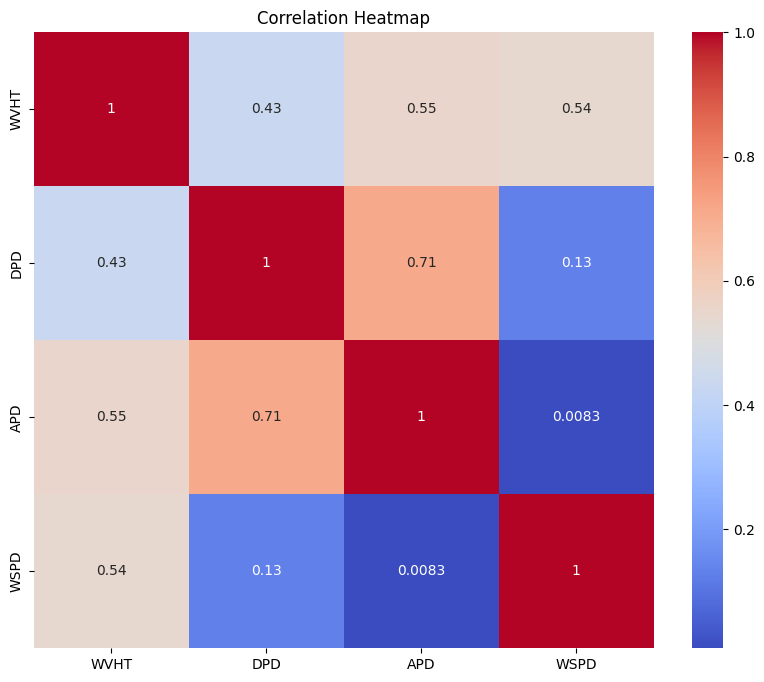

In [11]:
sample_cor = df[['WVHT', 'DPD', 'APD', 'WSPD']].sample(100000, random_state = 42)
plt.figure(figsize=(10, 8))
sns.heatmap(sample_cor.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Another intersting visual below, showing the buoy locations plotted alogside their lattitude and longitude on the x and y axis. It may be obvious to state, but when one plots lattitude and longitude, one creates a map.

One can see a rough outline of the United States below, showing the full east coast, gulf of mexico, west coast, great lakes, and the buoys along the coasts of alaska. There are even some buoys in the pacific, measuring wave data in Hawaii.

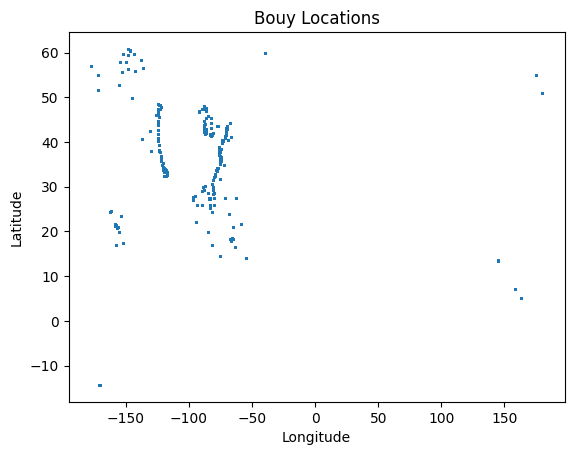

In [12]:
plt.figure()
plt.scatter(df['lon'], df['lat'], s = 1, alpha = 0.03)
plt.title('Bouy Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Dealing with NaN Values (imputing and discarding)

One of the issues with this dataset is that there is a high percentage of NaN values. Since the dataset is so large, and the high percentage of NaN values is not prevalant amongst all buoys, this is not a showstopper of an issue, but something to be mindful of.

There are often periods of time where buoys are simply not reporting data (due to maintenance or telemetry issues). The below table shows the percentage of NaN values there are in the data across all the features.

In [13]:
nan_pct = df.isna().mean().sort_values(ascending=False)*100
nan_pct.to_frame('percent_nan')

,percent_nan
APD,65.137188
DPD,56.374664
WVHT,54.755692
WSPD,22.581282
datetime,0.000000
bouy_id,0.000000
lat,0.000000
lon,0.000000


In [14]:
whvt_completeness = (df.groupby('bouy_id')['WVHT'].apply(lambda x: x.notna().mean() * 100).sort_values(ascending=False))
whvt_completeness.head(), whvt_completeness.tail()

(bouy_id
 45212    100.0
 45187    100.0
 46232    100.0
 46229    100.0
 52202    100.0
 Name: WVHT, dtype: float64,
 bouy_id
 41068    0.0
 42013    0.0
 46092    0.0
 46120    0.0
 46121    0.0
 Name: WVHT, dtype: float64)

Now, displaying the total completeness of data within one of the most important features (wave height) across all the bouys. As one can see, around 100 buoys contain near 100% completeness of data.

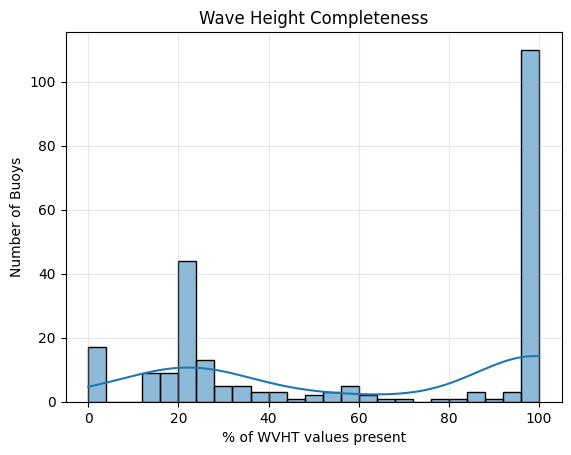

In [15]:
plt.figure()
sns.histplot(whvt_completeness, bins = 25, kde = True)
plt.title('Wave Height Completeness')
plt.xlabel('% of WVHT values present')
plt.ylabel('Number of Buoys')
plt.grid(True, alpha = 0.3)
plt.show()

Because of the missing values in the dataset, only buoys where there was a 40% or more data on wave height, 40% or more data on wave period, and 80% or more data on wind speed were kept for modeling.

The rest of the buoys that did not meet this data completeness threshold were subsequently dropped. The remainder of the dataset is 4.89MM rows long, so in terms of overall size, this still remains very rich to model.

In [16]:
df['DPD'] = pd.to_numeric(df['DPD'], errors='coerce')
df['APD'] = pd.to_numeric(df['APD'], errors='coerce')
df['period'] = df['DPD'].copy()
df['period'] = df['period'].fillna(df['APD'])
df['period'] = df['period'].where((df['period'] > 0) & (df['period'] < 40))

In [19]:
completeness = (df.groupby('bouy_id').agg(wvht_comp = ('WVHT', lambda s: s.notna().mean()),
                                        period_comp = ('period', lambda s: s.notna().mean()),
                                        wspd_comp = ('WSPD', lambda s: s.notna().mean()),
                                        rows = ('WVHT', 'size')).reset_index())
comp = completeness.query('wvht_comp > 0.4 & period_comp > 0.4 & wspd_comp > 0.8')
comp_bouys = comp['bouy_id'].tolist()
# print('fraction of dataset used:')
# print(len(comp_bouys) / len(comp))

df_clean = df[df['bouy_id'].isin(comp_bouys)].copy()
df_clean.shape

(4899106, 9)

After dropping the buoys that did not meet the specified threshold stated above, there still remained the issue of how to deal with the NaN values.

These values were imputed below using ffil and bffil, with a limit of 48 hours, so as not to fill too long of gaps and taint the data with impure values.


In [20]:
assert np.issubdtype(df_clean['datetime'].dtype, np.datetime64)

interp = ['WVHT', 'period', 'WSPD']

def data_impute(g: pd.DataFrame):
  g = g.sort_values('datetime').set_index('datetime')
  g[interp] = g[interp].interpolate(method='time', limit = 48, limit_direction = 'both')
  g[interp] = g[interp].ffill(limit = 48)
  g[interp] = g[interp].bfill(limit = 48)
  return g.reset_index()

df_clean = (df_clean.groupby('bouy_id', group_keys = False).apply(data_impute))
df_clean = df_clean.reset_index(drop = True)



/tmp/ipython-input-2472569977.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = (df_clean.groupby('bouy_id', group_keys = False).apply(data_impute))


Now viewing the overall percentage of NaN values that remain. These will be ultimately dropped later on, but as one can see the percentage has been trimmed significantly.

In [21]:
df_clean[interp].isna().mean()

,0
WVHT,0.096317
period,0.098457
WSPD,0.023796


## Feature Engineering: Surf Score and Surf Label

Prior to doing any further pruning of the dataset, some feature engineering must be done. As the overall goal is to use deep learning modeling to predict future wave conditions, it may be important to define what those future wave conditions are in a simple and digestable manner.

First, is the creation of a "Surf Score". This surf score represents a rating of surf conditions from 0-10. As one can see in the below function, it is defined by specific physical characteristics, measured by the buoys. For a wave to be surfable, it must be a certain height, have a long enough period between waves, and must not be overly windy. The below function, defines those characteristics and then creates a weighted score based off of these three values.

This surf score will ultimately be the target predicted variable in the regression modeling done in the modeling sections

In [22]:
def surfscore(df: pd.DataFrame):
  wvht = df['WVHT']
  wspd = df['WSPD']
  period = df['period']

  wvht_ft = wvht*3.28084
  wvht_scr = (wvht_ft - 0.5)/(1.7-0.5)
  wvht_scr = wvht_scr.clip(lower = 0, upper = 1)

  period_scr = (period - 5)/(11-5)
  period_scr = period_scr.clip(lower = 0, upper = 1)

  wve_scr = (0.5*wvht_scr) + (0.5*period_scr)

  wnd_k = wspd*1.94384
  wnd_pen = (wnd_k - 15)/(25-15)
  wnd_pen = wnd_pen.clip(lower = 0, upper = 1)
  wnd_fact = 1 - 0.3 * wnd_pen

  surf_scorebase = (wve_scr * wnd_fact).clip(lower = 0, upper = 1)
  surf_score = surf_scorebase*10

  allinpt = wvht.notna() & period.notna() & wspd.notna()
  surf_score = surf_score.where(allinpt, np.nan)
  return surf_score


An additional feature is created below for the binary classification modeling done further below. This feature is the surf_label and is defined as surfable (1) and not surfable (0). This sets a cut and dry cutoff point based on the physical wave characterstics, defining if one is able to surf or not surf.

This does not provide nuance as much as the surf score does, it only shows at the most basic level, will a surfer be able to take their board out and catch a wave. The waves they catch may or may not be "good", but this label does not define "goodness". This label only defines the base cut off by which a surfer will be able to catch a wave or not given the current conditions.

In [23]:
df_clean['surf_score'] = surfscore(df_clean)

df_clean['surf_label'] = pd.cut(df_clean['surf_score'], bins = [0,2.5,10], labels = ['not_surfable', 'surfable'],
                          include_lowest = True)
df_clean['surf_id'] = df_clean['surf_label'].cat.codes

Now, plotting the surf score across a random sample of the data. This shows that in general, most days are skewed toward bad to average (0-5). This is to be expected and shows that the surf score has been defined accurately- as most days are not "great" days to surf.

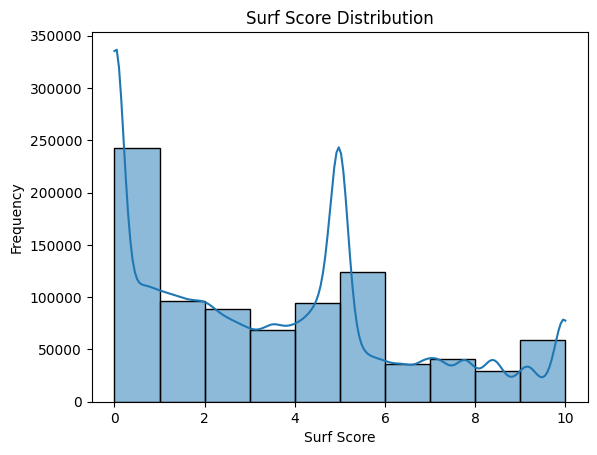

In [24]:
plt.figure()
sample = df_clean.sample(1000000, random_state =42)
sns.histplot(sample['surf_score'], bins = 10, kde = True)
plt.title('Surf Score Distribution')
plt.xlabel('Surf Score')
plt.ylabel('Frequency')
plt.show()

Additionally, the below table shows the proportion of surfable vs non-surfable days. As one can see there is a relatively even balance amongst the two classes, which is good.

In [25]:
df_clean['surf_label'].value_counts(dropna = False)
df_clean['surf_label'].value_counts(normalize = True)

,proportion
surf_label,
surfable,0.55933
not_surfable,0.44067


The below three plots show the three main physical wave features in this dataset (wave height, period, and wind speed) plotted against their wave score, and color-labeled by whether or not the measurement shows a wave that is surfable or not.

These are compelling visuals in that they show a lot of information about what is being recorded.

In the wave height vs surf score plot, one can see there is an obvious skew toward larger waves getting a higher score, but this is not always the case, because just as important as raw wave height is wave period.

In the wave period vs surf score plot, there is again a strong skew toward longer period waves with a greater surf score. This is ultimately becuase a longer period allows for greater surfability, due to the fact that when the period is longer, more power is generated by each wave (resulting in a better, more surfable wave).

Finally, looking at the wind speed vs surf score plot, as one can see, in this specific surf score there is not a huge emphasis on wind speed as there are period and wave height. Although harsher wind conditions, do penalize overall surf score, ultimately height and period were weighted more heavily in this exercise.

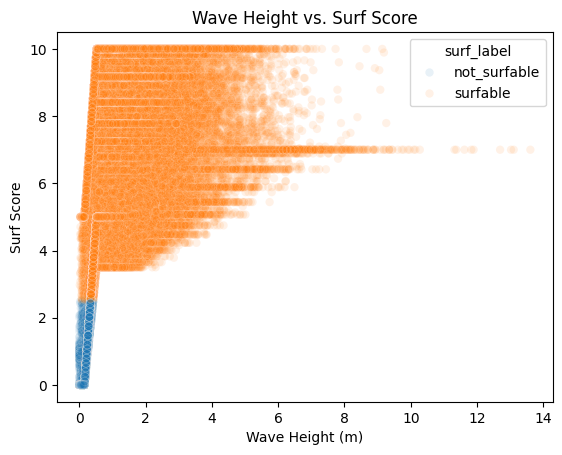

In [26]:
plt.figure()
sample = df_clean.sample(200000, random_state =42)
sns.scatterplot(data = sample, x = 'WVHT', y = 'surf_score', hue = 'surf_label', alpha = 0.1)
plt.title('Wave Height vs. Surf Score')
plt.xlabel('Wave Height (m)')
plt.ylabel('Surf Score')
plt.show()


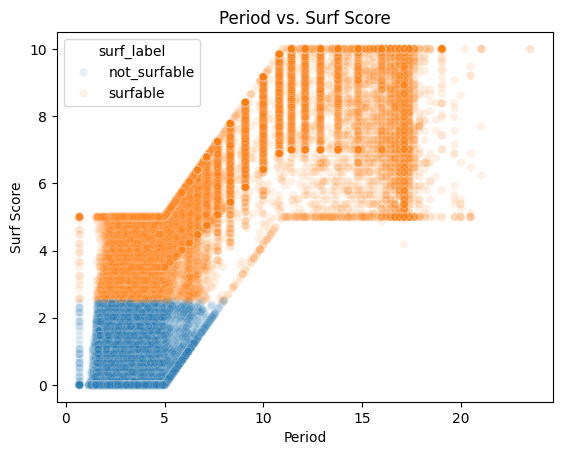

In [27]:
plt.figure()
sample = df_clean.sample(200000, random_state =42)
sns.scatterplot(data = sample, x = 'DPD', y = 'surf_score', hue = 'surf_label', alpha = 0.1)
plt.title('Period vs. Surf Score')
plt.xlabel('Period')
plt.ylabel('Surf Score')
plt.show()

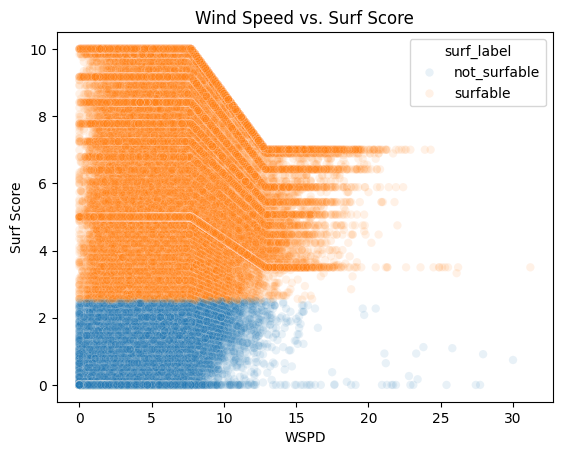

In [28]:
plt.figure()
sample = df_clean.sample(200000, random_state =42)
sns.scatterplot(data = sample, x = 'WSPD', y = 'surf_score', hue = 'surf_label', alpha = 0.1)
plt.title('Wind Speed vs. Surf Score')
plt.xlabel('WSPD')
plt.ylabel('Surf Score')
plt.show()

## Final Dataframe Pruning and Creation of Model_df

After feature enginering the surf score (0-10) and surf label (surfable vs not surfable), some final dataframe pruning has to occur prior to moving forward into the data preprocessing, and then subsequent modeling

First, the final NaN values need to be dropped, which is what is done below. These are the last NaNs left over from the data imputation, and were only a small subset.

In [29]:
model_df = df_clean.dropna(subset = ['WVHT', 'period', 'WSPD', 'surf_score', 'surf_label']).copy()
model_df.shape

(4305287, 12)

Additionally, datetime year, month, day, hour values are created. Then sin/cos encoding the day of year, as well as hour.

In [30]:
model_df['year'] = model_df['datetime'].dt.year
model_df['month'] = model_df['datetime'].dt.month
model_df['day'] = model_df['datetime'].dt.day
model_df['hour'] = model_df['datetime'].dt.hour

model_df['doy_sin'] = np.sin(2 * np.pi * model_df['datetime'].dt.dayofyear / 365)
model_df['doy_cos'] = np.cos(2 * np.pi * model_df['datetime'].dt.dayofyear / 365)
model_df['hour_sin'] = np.sin(2 * np.pi * model_df['datetime'].dt.hour / 24)
model_df['hour_cos'] = np.cos(2 * np.pi * model_df['datetime'].dt.hour / 24)

feat = ['WVHT', 'period', 'WSPD',
        'lat', 'lon', 'doy_sin', 'doy_cos', 'hour_sin', 'hour_cos']

targ_reg = 'surf_score'
targ_cls = 'surf_id'

col = feat + [targ_reg, targ_cls]
model_df = model_df.dropna(subset = col).sort_values('datetime').reset_index(drop = True)


Finally checking to ensure there are no more NaN values and viewing the final dataframe shape.

In [31]:
model_df[col].isna().sum()

,0
WVHT,0
period,0
WSPD,0
lat,0
lon,0
doy_sin,0
doy_cos,0
hour_sin,0
hour_cos,0
surf_score,0


In [32]:
model_df.shape

(4305287, 20)

## Data Preprocessing for Modeling

Now that the model_df dataframe is adequately pruned, the data is finally ready to be preprocessed for modeling. The steps that will be taken are below:


1.   Data must be split into a Train/Test/Validation set
2.   Features must be scaled using Standard Scaler
3.   Data must be sequenced into "sliding windows" for the LSTM and CNN models to understand time series patterns

Using a 70/15/15 split between train, validation and test data below.

In [33]:
model_df = model_df.sort_values('datetime').reset_index(drop = True)


train_df = model_df.iloc[:int(0.7 * len(model_df))]
val_df = model_df.iloc[int(0.7 * len(model_df)):int(0.85 * len(model_df))]
test_df = model_df.iloc[int(0.85 * len(model_df)):]

Now scaling the features using standard scaler, so the model can adequately understand them

In [34]:
scaler = StandardScaler()
scale_feat = ['WVHT', 'period', 'WSPD', 'doy_sin', 'doy_cos',
              'hour_sin', 'hour_cos']
train_df.loc[:, scale_feat] = scaler.fit_transform(train_df[scale_feat])
val_df.loc[:, scale_feat] = scaler.transform(val_df[scale_feat])
test_df.loc[:, scale_feat] = scaler.transform(test_df[scale_feat])


Finally, one of the most important steps that will allow the neural network models to learn from the data is sequencing the data into "sliding-windows". This step converts the raw time-series data into sequences that the LSTMs and CNNs below can train on. These models need fixed lengths of times to learn on, and this sequencing does just that for them. It creates 24 hour lookback and lookforward windows, for the models to train on, grouped by buoy id.

Two different sequencing functions are created below. The first sequencer is for the regression task, where the target is the surf score. The second is for the binary classification task, where the target is the surf label (surfable or not surfable).

In [35]:
def sequencer(df, feats, target, lookback = 24, horizon = 24):
  X, y = [], []
  df_sorted = df.sort_values(['bouy_id', 'datetime'])
  for bouy_id, g in df_sorted.groupby('bouy_id'):
    val = g[feats + [target]].values
    if len(val) < lookback + horizon:
      continue
    for i in range(0, len(val)-lookback-horizon + 1):
      X.append(val[i: i + lookback, : -1])
      y.append(val[i + lookback + horizon -1, -1])
  return np.array(X), np.array(y)

In [36]:
lookback = 24
horizon = 24
X_train, y_train = sequencer(train_df, feat, targ_reg, lookback, horizon)
X_val, y_val = sequencer(val_df, feat, targ_reg, lookback, horizon)
X_test, y_test = sequencer(test_df, feat, targ_reg, lookback, horizon)

In [37]:
X_train.shape, y_train.shape

((3011773, 24, 9), (3011773,))

In [38]:
def sequencer_cls(df, feats, target, lookback = 24, horizon = 24):
  X, y = [], []
  df_sorted = df.sort_values(['bouy_id', 'datetime'])
  for bouy_id, g in df_sorted.groupby('bouy_id'):
    feat_val = g[feats].values
    label = g[target].values.astype(int)

    if len(label) < lookback + horizon:
      continue
    for i in range(0, len(label)-lookback-horizon+1):
      X.append(feat_val[i: i + lookback, :])
      y.append(label[i + lookback + horizon -1])
  return np.array(X), np.array(y)

In [39]:
lookback = 24
horizon = 24
X_train_cls, y_train_cls = sequencer_cls(train_df, feat, targ_cls, lookback, horizon)
X_val_cls, y_val_cls = sequencer_cls(val_df, feat, targ_cls, lookback, horizon)
X_test_cls, y_test_cls = sequencer_cls(test_df, feat, targ_cls, lookback, horizon)

In [40]:
X_train_cls.shape, y_train_cls.shape

((3011773, 24, 9), (3011773,))

## EDA Summary

A quick recap of what was completed during EDA:

1. Data was loaded into the notebook and visualizations on wave height, wave period, and wind speed distribution were created. Additionally a correlation heatmap, alongside a visual of the buoy locations were created.

2. Buoys where NaN values exist were discarded if they did not meet a certain threshold of data completeness. Those that were leftover had the NaN values filled with forward fill and back fill.

3. Feature engineering was done to create the surf label and surf score values, which will be our target predicted features in modeling.

4. Final dataframe pruning was done to drop the remaining NaN values and create sin/cos encoded time values.

5. Data pre-processing step occured where train/test/val split was done, feature scaling was done, and then sequencing of the time-series data into "sliding-windows" for the CNN and RNN models to learn from.

# Modeling

## Creation of Dataframe for Storing Model Results

Initializing the creation of a results table to hold the regression model and binary classification model results. The results across all six models below will be stored in these tables to be viewed in the final results and analysis section

In [41]:
reg_results = []
cls_results = []

## Baseline for Model Comparison

Before jumping into the first model, two baselines are created below. These are essential to have something to evaluate the models' efficacy against.

For the surf score (regression task), the baseline that is created is a mean predictor, which is as simple as it sounds. It simply represents the mean surf score across the dataset and then computes the RMSE of this mean value. RMSE is the main metric that will be used to evaluate the regression models' efficacy, so this is  important to calculate below. The RMSE for this baseline is 3.05. As long as the model beats this metric, we can know that it is learning something from the data.

In [42]:
bl_pred = np.full_like(y_test, fill_value = y_train.mean(), dtype = float)
bl_mse = mean_squared_error(y_test, bl_pred)
bl_rmse = np.sqrt(bl_mse)
print(bl_rmse)

reg_results.append({'model': 'baseline_mean',
                    'val_rmse': float(bl_rmse),
                    'val_loss': None,
                    'test_rmse': float(bl_rmse),
                    'test_loss': None,
                    })

3.047949794036816


For the surf label (classification task), the baseline that is created is a majority class predictor. It simply represents the majority class of the dataset. The subsequent metric computed from this is the accuracy of this majority class. This is the amount of times it correctly guesses the actual surfability label, which is as one can see below, 0.61. So, if the model guess more accurately than ~61% of the time, it should be learning something from the data.

In [43]:
value, count = np.unique(y_train_cls, return_counts = True)
maj_cls = value[np.argmax(count)]
#print(maj_cls)

bl_pred_cls = np.full_like(y_test_cls, fill_value = maj_cls, dtype = float)
bl_acc_cls = (bl_pred_cls == y_test_cls).mean()
print(bl_acc_cls)

cls_results.append({'model': 'baseline_maj_cls',
                    'val_acc': float(bl_acc_cls),
                    'val_loss': None,
                    'test_acc': float(bl_acc_cls),
                    'test_loss': None,
                    })

0.608113816441326


# RNN Models 1A and 1B (LSTM Regression & LSTM Classification)

The first two models that will be used on this problem are RNN models. First a vanilla LSTM model (model 1A) is used on the regression task (targeting the surf score from 0-10). Second, another vanilla LSTM Model (model 1B) is used on the classification task to predict the surfability. Each of these models will only predict 24 hours ahead, as defined by the sequencer, previously created in the data preprocessing section.

## 1A. LSTM Regression Model Architecture

The 1A LSTM model architecture first begins with an input and two LSTM layers, with the first layer at 64 units and the second layer at 32 units. Each layer has a dropout to prevent overfitting. There are two dense layers, one with a relu activation and the second a linear activation at the output for the regression task. The final output is  a surf score, 24 hours in the future, scaled from 0-10.

In [44]:
n_ts = X_train.shape[1]
n_feat = X_train.shape[2]

def model_LSTM_reg():
  inputs = layers.Input(shape = (n_ts, n_feat))
  x = layers.LSTM(64, return_sequences = True)(inputs)
  x = layers.Dropout(0.2)(x)

  x = layers.LSTM(32)(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Dense(32, activation = 'relu')(x)
  x = layers.Dense(1, activation = 'linear')(x)

  model = models.Model(inputs = inputs, outputs = x)

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                loss = 'mse',
                metrics = [tf.keras.metrics.MeanAbsoluteError(name = 'mae'),
                           tf.keras.metrics.RootMeanSquaredError(name='rmse')])
  return model

lstm_reg = model_LSTM_reg()
lstm_reg.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 64)         │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,449 (126.75 KB)

 Trainable params: 32,449 (126.75 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
stoppage = callbacks.EarlyStopping(monitor = 'val_rmse', patience = 3, restore_best_weights = True)
lr_red = callbacks.ReduceLROnPlateau(monitor = 'val_rmse', patience = 2, factor = 0.5, verbose = 1)

## 1A. LSTM Regression Model Training

Fitting the model below on the data, over the course of a maximum of 20 epochs with early stoppage in place, as well as learning rate reduction.

In [46]:
hist_1A = lstm_reg.fit(X_train, y_train, validation_data = (X_val, y_val),
                    epochs = 20, batch_size = 512, callbacks = [stoppage, lr_red],
                    verbose = 1)

Epoch 1/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 3.2817 - mae: 1.3170 - rmse: 1.7875 - val_loss: 2.4881 - val_mae: 1.1957 - val_rmse: 1.5774 - learning_rate: 0.0010
Epoch 2/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 2.4232 - mae: 1.1182 - rmse: 1.5567 - val_loss: 2.4278 - val_mae: 1.1582 - val_rmse: 1.5582 - learning_rate: 0.0010
Epoch 3/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 2.3738 - mae: 1.1013 - rmse: 1.5407 - val_loss: 2.4676 - val_mae: 1.1962 - val_rmse: 1.5708 - learning_rate: 0.0010
Epoch 4/20
5881/5883 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3437 - mae: 1.0903 - rmse: 1.5309
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 2.3437 - mae: 1.0903 - rmse: 1.5309 - val_loss: 2.4893 - val_mae: 1.2117 - val_rmse: 1.5778 - learning_rate: 0.0010
Epoch 5/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 2.3133 - mae: 1.0795 - rmse: 1.5209 - val_loss: 2.3412 - v

## 1A. LSTM Regression Model Results

Briefly viewing the modeling results, evaluted on the test data, and printing the Loss, MAE, and RMSE. Then logging the test and validation metrics to the results table.

A detailed discussion of these results will be done in the "Summarized Results and Analysis" section near the bottom of the notebook, where these results will be compared to the other models as well.

In [47]:
test_loss1A, test_mae1A, test_rmse1A = lstm_reg.evaluate(X_test, y_test, verbose = 1)
print('Test Loss: ', test_loss1A, ' Test MAE: ', test_mae1A, ' Test RMSE: ', test_rmse1A)

20123/20123 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - loss: 2.3578 - mae: 1.1287 - rmse: 1.5239
Test Loss:  1.8822468519210815  Test MAE:  1.0387417078018188  Test RMSE:  1.3719500303268433


In [48]:
val_loss1A = np.min(hist_1A.history['val_loss'])
val_rmse1A = np.min(hist_1A.history['val_rmse'])
print('Val Loss: ', val_loss1A, ' Val RMSE: ', val_rmse1A)

Val Loss:  2.3411736488342285  Val RMSE:  1.5300893783569336


In [49]:
y_predt = lstm_reg.predict(X_test, batch_size = 512)

1258/1258 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [50]:
reg_results.append({'model': '1A_LSTM_REG',
                    'val_rmse': val_rmse1A,
                    'val_loss': val_loss1A,
                    'test_rmse': test_rmse1A,
                    'test_loss': test_loss1A,
                    })

## 1B. LSTM Classification Model Architecture

The 1B LSTM model architecture is relatively similar to the 1A architecture, except the task is classification, rather than regression. It first begins with an input and two LSTM layers, with the first layer at 64 units and the second layer at 32 units. Each layer has a dropout to prevent overfitting. There are two dense layers, one with a relu activation and the second a softmax activation at the output for the binary classification task. The final output is a binary result of 1 or 0, representing surfability 24 hours in the future.

In [51]:
n_ts = X_train_cls.shape[1]
n_feat = X_train_cls.shape[2]
num_class = len(np.unique(y_train_cls))

def model_LSTM_cls():
  inputs = layers.Input(shape = (n_ts, n_feat))
  x = layers.LSTM(64, return_sequences = True)(inputs)
  x = layers.Dropout(0.2)(x)

  x = layers.LSTM(32)(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Dense(32, activation = 'relu')(x)
  x = layers.Dense(num_class, activation = 'softmax')(x)

  model = models.Model(inputs = inputs, outputs = x)

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                loss = 'sparse_categorical_crossentropy',
                metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')]
                            )
  return model

lstm_cls = model_LSTM_cls()
lstm_cls.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,482 (126.88 KB)

 Trainable params: 32,482 (126.88 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
stoppage = callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3, restore_best_weights = True)
lr_red = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, factor = 0.5, verbose = 1)

## 1B. LSTM Classification Model Training

Fitting the model below on the data, over the course of a maximum of 20 epochs with early stoppage in place, as well as learning rate reduction.

In [53]:
hist_1B = lstm_cls.fit(X_train_cls, y_train_cls, validation_data = (X_val_cls, y_val_cls),
                    epochs = 20, batch_size = 512, callbacks = [stoppage, lr_red],
                    verbose = 1)

Epoch 1/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 45s 7ms/step - accuracy: 0.8198 - loss: 0.3824 - val_accuracy: 0.8693 - val_loss: 0.2811 - learning_rate: 0.0010
Epoch 2/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.8395 - loss: 0.3476 - val_accuracy: 0.8709 - val_loss: 0.2759 - learning_rate: 0.0010
Epoch 3/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.8414 - loss: 0.3421 - val_accuracy: 0.8684 - val_loss: 0.2819 - learning_rate: 0.0010
Epoch 4/20
5877/5883 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8428 - loss: 0.3391
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.8428 - loss: 0.3391 - val_accuracy: 0.8707 - val_loss: 0.2754 - learning_rate: 0.0010
Epoch 5/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.8443 - loss: 0.3353 - val_accuracy: 0.8694 - val_loss: 0.2780 - learning_rate: 5.0000e-04


## 1B. LSTM Classification Model Results

Briefly viewing the modeling results, evaluted on the test data, and printing a classification report, as well as the Loss and Accuracy metrics. Then logging the test and validation metrics to the results table.

A detailed discussion of these results will be done in the "Summarized Results and Analysis" section near the bottom of the notebook, where these results will be compared to the other models as well.

In [54]:
y_prod = lstm_cls.predict(X_test_cls, batch_size = 512)
y_pred_cls = y_prod.argmax(axis = 1)

print(classification_report(y_test_cls, y_pred_cls, digits = 3))

1258/1258 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
              precision    recall  f1-score   support

           0      0.805     0.887     0.844    252341
           1      0.922     0.862     0.891    391573

    accuracy                          0.872    643914
   macro avg      0.864     0.875     0.868    643914
weighted avg      0.876     0.872     0.873    643914



In [55]:
test_loss1B, test_acc1B = lstm_cls.evaluate(X_test_cls, y_test_cls, verbose = 1)

print('Test Loss: ', test_loss1B, ' Test Acc: ', test_acc1B)

20123/20123 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.8432 - loss: 0.3370
Test Loss:  0.28608179092407227  Test Acc:  0.8718058466911316


In [56]:
val_loss1B = np.min(hist_1B.history['val_loss'])
val_acc1B = np.max(hist_1B.history['val_accuracy'])
print('Val Loss: ', val_loss1B, ' Val Acc: ', val_acc1B)

Val Loss:  0.2754476070404053  Val Acc:  0.8709017038345337


In [57]:
cls_results.append({'model': '1B_LSTM_CLS',
                    'val_acc': val_acc1B,
                    'val_loss': val_loss1B,
                    'test_acc': test_acc1B,
                    'test_loss': test_loss1B,
                    })

# CNN Models 2A and 2B (1D CNN Regression & 1D CNN Classification)

The second set of models that will be used on this problem are CNN models. First a CNN-1D model (model 2A) is used on the regression task (targeting the surf score from 0-10). Second, another CNN-1D Model (model 1B) is used on the classification task to predict the surfability. Each of these models will only predict 24 hours ahead, as defined by the sequencer, previously created in the data preprocessing section.

## 2A.  1D CNN Regression Model Architecture

The 2A 1D CNN Model architecture consists of 1 dimensional convolutional layers (as opposed to the reccurent layers in the RNNs in 1A and 1B). There are two 1D convultional layers at 32 and 64. There are dropouts at each layer, and max pooling to prevent overfitting. Finally, there are two dense layers, one with a relu activation and the last with a linear activation for the regression task of applying a surf score (0-10) 24 hours in the future, based off of current conditions.

In [58]:
n_ts = X_train.shape[1]
n_feat = X_train.shape[2]

def CNN_reg():

  inputs = layers.Input(shape = (n_ts, n_feat))

  x = layers.Conv1D(32, kernel_size = 3, padding = 'causal' , activation = 'relu')(inputs)
  x = layers.MaxPooling1D(pool_size = 2)(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Conv1D(64, kernel_size = 3, padding = 'causal', activation = 'relu')(x)
  x = layers.MaxPooling1D(pool_size = 2)(x)
  x = layers.Dropout(0.2)(x)

  x = layers.GlobalAveragePooling1D()(x)

  x = layers.Dense(64, activation = 'relu')(x)
  x = layers.Dense(1, activation = 'linear')(x)

  model = models.Model(inputs = inputs, outputs = x)
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                loss = 'mse',
                metrics = [tf.keras.metrics.MeanAbsoluteError(name = 'mae'),
                           tf.keras.metrics.RootMeanSquaredError(name = 'rmse')])

  return model


In [59]:
cnn_reg = CNN_reg()
cnn_reg.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 24, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 24, 32)         │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,329 (44.25 KB)

 Trainable params: 11,329 (44.25 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
stoppage2 = callbacks.EarlyStopping(monitor = 'val_rmse', patience = 3, restore_best_weights = True)
lr_red2 = callbacks.ReduceLROnPlateau(monitor = 'val_rmse', patience = 2, factor = 0.5, verbose = 1)

## 2A. 1D CNN Regression Model Training

Fitting the model below on the data, over the course of a maximum of 20 epochs with early stoppage in place, as well as learning rate reduction.

In [61]:
hist_2A = cnn_reg.fit(X_train, y_train, validation_data = (X_val, y_val),
                           epochs = 20, batch_size = 512, callbacks = [stoppage2, lr_red2],
                           verbose = 1)

Epoch 1/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 3.9245 - mae: 1.4719 - rmse: 1.9515 - val_loss: 3.0300 - val_mae: 1.3645 - val_rmse: 1.7407 - learning_rate: 0.0010
Epoch 2/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 2.6261 - mae: 1.1906 - rmse: 1.6205 - val_loss: 2.6230 - val_mae: 1.2599 - val_rmse: 1.6196 - learning_rate: 0.0010
Epoch 3/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 2.5610 - mae: 1.1671 - rmse: 1.6003 - val_loss: 2.5147 - val_mae: 1.2142 - val_rmse: 1.5858 - learning_rate: 0.0010
Epoch 4/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 2.5180 - mae: 1.1528 - rmse: 1.5868 - val_loss: 2.6510 - val_mae: 1.2334 - val_rmse: 1.6282 - learning_rate: 0.0010
Epoch 5/20
5874/5883 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4992 - mae: 1.1465 - rmse: 1.5809
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 2.4992 - mae: 1.1465 - rmse: 1.5809 - val_loss: 2.6113 - v

## 2A. 1D CNN Regression Model Results

Briefly viewing the modeling results, evaluted on the test data, and printing a classifiaction report, as well as the Loss and Accuracy metrics. Then logging the test and validation metrics to the results table.

A detailed discussion of these results will be done in the "Summarized Results and Analysis" section near the bottom of the notebook, where these results will be compared to the other models as well.

In [62]:
test_loss2A, test_mae2A, test_rmse2A = cnn_reg.evaluate(X_test, y_test, verbose = 1)
print('Test Loss: ', test_loss2A, ' Test MAE: ', test_mae2A, ' Test RMSE: ', test_rmse2A)

20123/20123 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 2.5199 - mae: 1.1754 - rmse: 1.5764
Test Loss:  2.0066797733306885  Test MAE:  1.0756704807281494  Test RMSE:  1.416573166847229


In [63]:
val_loss2A = np.min(hist_2A.history['val_loss'])
val_mae2A = np.min(hist_2A.history['val_mae'])
val_rmse2A = np.min(hist_2A.history['val_rmse'])
print('Val Loss: ', val_loss2A, ' Val MAE: ', val_mae2A, ' Val RMSE: ', val_rmse2A)

Val Loss:  2.41632080078125  Val MAE:  1.1708316802978516  Val RMSE:  1.5544519424438477


In [64]:
reg_results.append({'model': '2A_1DCNN_REG',
                    'val_rmse': val_rmse2A,
                    'val_loss': val_loss2A,
                    'test_rmse': test_rmse2A,
                    'test_loss': test_loss2A,
                    })

## 2B. 1D CNN Classification Model Architecture

The 2B 1D CNN Model architecture is similar to that of the 2A architecture, with the exception that it performs a classification task, rather than a regression task. It consists of 1 dimensional convolutional layers (as opposed to the reccurent layers in the RNNs in 1A and 1B). There are two 1D convultional layers at 32 and 64. There are dropouts at each layer, and max pooling to prevent overfitting. Finally, there are two dense layers, one with a relu activation and the last with a softmax activation for the classification task of applying a surfability label (surfable or not surfable) 24 hours in the future, based off of current conditions.

In [65]:
n_ts = X_train_cls.shape[1]
n_feat = X_train_cls.shape[2]
num_class = len(np.unique(y_train_cls))

def CNN_cls():

  inputs = layers.Input(shape = (n_ts, n_feat))

  x =layers.Conv1D(32, kernel_size = 3, padding = 'causal', activation = 'relu')(inputs)
  x = layers.MaxPooling1D(pool_size = 2)(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Conv1D(64, kernel_size = 3, padding = 'causal', activation = 'relu')(x)
  x = layers.MaxPooling1D(pool_size = 2)(x)
  x = layers.Dropout(0.2)(x)

  x = layers.GlobalAveragePooling1D()(x)

  x = layers.Dense(64, activation = 'relu')(x)
  x = layers.Dense(num_class, activation = 'softmax')(x)

  model = models.Model(inputs = inputs, outputs = x)

  model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
      loss = 'sparse_categorical_crossentropy',
      metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')])

  return model


In [66]:
cnn_cls = CNN_cls()
cnn_cls.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 24, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 24, 32)         │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,394 (44.51 KB)

 Trainable params: 11,394 (44.51 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
stoppage3 = callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3, restore_best_weights = True)
lr_red3 = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, factor = 0.5, verbose = 1)

## 2B. 1D CNN Classification Model Training

Fitting the model below on the data, over the course of of a maximum of 20 epochs with early stoppage in place, as well as learning rate reduction.

In [68]:
hist_2B = cnn_cls.fit(X_train_cls, y_train_cls, validation_data = (X_val_cls, y_val_cls),
                           epochs = 20, batch_size = 512, callbacks = [stoppage3, lr_red3],
                           verbose = 1)

Epoch 1/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.7715 - loss: 0.4917 - val_accuracy: 0.8611 - val_loss: 0.3050 - learning_rate: 0.0010
Epoch 2/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8283 - loss: 0.3692 - val_accuracy: 0.8626 - val_loss: 0.2996 - learning_rate: 0.0010
Epoch 3/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8318 - loss: 0.3626 - val_accuracy: 0.8638 - val_loss: 0.2906 - learning_rate: 0.0010
Epoch 4/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.8330 - loss: 0.3597 - val_accuracy: 0.8606 - val_loss: 0.3003 - learning_rate: 0.0010
Epoch 5/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8339 - loss: 0.3580 - val_accuracy: 0.8670 - val_loss: 0.2857 - learning_rate: 0.0010
Epoch 6/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8337 - loss: 0.3576 - val_accuracy: 0.8673 - val_loss: 0.2861 - learning_rate: 0.0010
Epoch 7/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8

## 2B. 1D CNN Classification Model Results

Briefly viewing the modeling results, evaluted on the test data, and printing a classifiaction report, as well as the Loss and Accuracy metrics. Then logging the test and validation metrics to the results table.

A detailed discussion of these results will be done in the "Summarized Results and Analysis" section near the bottom of the notebook, where these results will be compared to the other models as well.

In [69]:
test_loss2B, test_acc2B = cnn_cls.evaluate(X_test_cls, y_test_cls, verbose = 1)
print('Test Loss: ', test_loss2B, ' Test ACC: ', test_acc2B)

20123/20123 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.8420 - loss: 0.3428
Test Loss:  0.29208943247795105  Test ACC:  0.8696083426475525


In [70]:
y_proba_cnn_cls = cnn_cls.predict(X_test_cls, batch_size = 512)
y_pred_cnn_cls = y_proba_cnn_cls.argmax(axis=1)

1258/1258 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [71]:
print(classification_report(y_test_cls, y_pred_cnn_cls))


              precision    recall  f1-score   support

           0       0.81      0.87      0.84    252341
           1       0.91      0.87      0.89    391573

    accuracy                           0.87    643914
   macro avg       0.86      0.87      0.86    643914
weighted avg       0.87      0.87      0.87    643914



In [72]:
print(confusion_matrix(y_test_cls, y_pred_cnn_cls))

[[219092  33249]
 [ 50712 340861]]


In [73]:
val_loss2B = np.min(hist_2B.history['val_loss'])
val_acc2B = np.max(hist_2B.history['val_accuracy'])
print('Val Loss: ', val_loss2B, ' Val ACC: ', val_acc2B)

Val Loss:  0.2827869653701782  Val ACC:  0.8691249489784241


In [74]:
cls_results.append({'model': '2B_1DCNN_CLS',
                    'val_acc': val_acc2B,
                    'val_loss': val_loss2B,
                    'test_acc': test_acc2B,
                    'test_loss': test_loss2B,
                    })

# Models 3A and 3B: Hyperparameter Tuning on Bidirectional LSTM Regression and LSTM Classification Models

The third set of models that are used are much more nuanced than the first two. They are Bidirectional LSTMS, that utilize hyperparameter tuning to loop through 4 different sets of parameters and idenitfy the most optimal set of parameters to run.  First a BILSTM (model 3A) is used on the regression task (targeting the surf score from 0-10). Then another BILSTM Model (model 1B) is used on the classification task to predict the surfability. Each of these models will only predict 24 hours ahead, as defined by the sequencer, previously created in the data preprocessing section.

The hyperparameter sweep will be shown below, as well as the different configurations used in this tuning sweep.

## 3A. Bidrectional LSTM Regression Architecture

The 3A Bidirectional LSTM architecture is a slightly more advanced architecure than that of the straight-forward LSTM used in 1A. As opposed to a normal LSTM, Bidirectional LSTMS take in the backward and forward 24 hour sequence that is passed to it, rather than just reading the temporal pattern forward. This allows it to take in more information on the pattern and potentially yield a better result.

In this architecture there are two bidirectional layers with dropout rates and layer units defined by the hyperparameter sweep. Additionally there are two dense layers, one with a relu activation and one with a linear activation for the regression task, that will be the output. This output results in a surf score from 0-10, representing the 24 hour look ahead forecast based on present conditions input.

In [75]:
n_ts = X_train.shape[1]
n_feat = X_train.shape[2]

def tune_LSTM_reg(u1, u2, u3, do, lr):
  inputs = layers.Input(shape = (n_ts, n_feat))
  x = layers.Bidirectional(layers.LSTM(u1, return_sequences = True))(inputs)
  x = layers.Dropout(do)(x)

  x = layers.Bidirectional(layers.LSTM(u2))(x)
  x = layers.Dropout(do)(x)

  x = layers.Dense(u3, activation = 'relu')(x)

  x = layers.Dense(1, activation = 'linear')(x)

  model = models.Model(inputs = inputs, outputs = x)

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
                loss = 'mse',
                metrics = [tf.keras.metrics.MeanAbsoluteError(name = 'mae'),
                           tf.keras.metrics.RootMeanSquaredError(name='rmse')])
  return model

## 3A. Bidrectional LSTM Regression Training with Hyperparameter Tuning

Four sets of parameters are tuned in this exercise. There are three variables representing different units across dense layers, and then one variable representing the dropout rate, and a final variable representing the learning rate. Fitting the model below on the data, over the course of of a maximum of 20 epochs with early stoppage in place, as well as learning rate reduction.

In [76]:
hyperparam_sweep = [{'u1': 64, 'u2': 32, 'u3': 32, 'do': 0.2, 'lr': 1e-3},
                    {'u1': 96, 'u2': 48, 'u3': 64, 'do': 0.3, 'lr': 1e-3},
                    {'u1': 128, 'u2': 64, 'u3': 64, 'do': 0.3, 'lr': 5e-4},
                    {'u1': 64, 'u2': 32, 'u3': 64, 'do': 0.2, 'lr': 5e-4}]

In [77]:
best_model = None
best_param = None
best_val_rmse = np.inf

for i, param in enumerate(hyperparam_sweep, start = 1):
  print(i,'/4')
  print(param)
  model = tune_LSTM_reg(**param)

  stoppage_param = callbacks.EarlyStopping(monitor = 'val_rmse', patience = 3, restore_best_weights = True)
  lr_red_param = callbacks.ReduceLROnPlateau(monitor = 'val_rmse', patience = 2, factor = 0.5, verbose = 1)

  hist_3A = model.fit(X_train, y_train, validation_data = (X_val, y_val),
                      epochs = 20, batch_size = 512, callbacks = [stoppage_param, lr_red_param],
                      verbose = 1)

  best_val = min(hist_3A.history['val_rmse'])
  print(best_val)
  if best_val < best_val_rmse:
    best_val_rmse = best_val
    best_model = model
    best_param = param
    best_hist = hist_3A.history


1 /4
{'u1': 64, 'u2': 32, 'u3': 32, 'do': 0.2, 'lr': 0.001}
Epoch 1/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - loss: 2.9766 - mae: 1.2598 - rmse: 1.7115 - val_loss: 2.3843 - val_mae: 1.1345 - val_rmse: 1.5441 - learning_rate: 0.0010
Epoch 2/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 78s 13ms/step - loss: 2.4131 - mae: 1.1161 - rmse: 1.5534 - val_loss: 2.2595 - val_mae: 1.0748 - val_rmse: 1.5032 - learning_rate: 0.0010
Epoch 3/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 77s 13ms/step - loss: 2.3691 - mae: 1.1002 - rmse: 1.5392 - val_loss: 2.3111 - val_mae: 1.0785 - val_rmse: 1.5202 - learning_rate: 0.0010
Epoch 4/20
5879/5883 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.3390 - mae: 1.0887 - rmse: 1.5294
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 78s 13ms/step - loss: 2.3390 - mae: 1.0887 - rmse: 1.5294 - val_loss: 2.2688 - val_mae: 1.0678 - val_rmse: 1.5063 - learning_rate: 0.0010
Epoch 5/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 77s 13ms/step 

## 3A. Bidrectional LSTM Regression Results

Briefly viewing the modeling results, evaluted on the test data, and printing a classifiaction report, as well as the Loss and Accuracy metrics. Then logging the test and validation metrics to the results table.

A detailed discussion of these results will be done in the "Summarized Results and Analysis" section near the bottom of the notebook, where these results will be compared to the other models as well.

In [78]:
print('Best Parameter: ', best_param)
test_loss3A, test_mae3A, test_rmse3A = best_model.evaluate(X_test, y_test, verbose = 1)
print('Test Loss: ', test_loss3A, ' Test MAE: ', test_mae3A, ' Test RMSE: ', test_rmse3A)

Best Parameter:  {'u1': 128, 'u2': 64, 'u3': 64, 'do': 0.3, 'lr': 0.0005}
20123/20123 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - loss: 2.2759 - mae: 1.0496 - rmse: 1.4960
Test Loss:  1.770416498184204  Test MAE:  0.9506440162658691  Test RMSE:  1.3305699825286865


In [79]:
val_loss3A = np.min(best_hist['val_loss'])
val_mae3A = np.min(best_hist['val_mae'])
val_rmse3A = np.min(best_hist['val_rmse'])
print('Val Loss: ', val_loss3A, ' Val MAE: ', val_mae3A, ' Val RMSE: ', val_rmse3A)

Val Loss:  2.2440412044525146  Val MAE:  1.054802417755127  Val RMSE:  1.4980124235153198


In [80]:
reg_results.append({'model': '3A_BILSTM_REG',
                    'val_rmse': val_rmse3A,
                    'val_loss': val_loss3A,
                    'test_rmse': test_rmse3A,
                    'test_loss': test_loss3A,
                    })

## 3B. Bidrectional LSTM Classification Architecture

The 3B Bidirectional LSTM architecture is similar to that of 3A, in that it is a a slightly more advanced architecure than that of the straight-forward LSTM used in 1A. As opposed to a normal LSTM, Bidirectional LSTMS take in the backward and forward 24 hour sequence that is passed to it, rather than just reading the temporal pattern forward. This allows it to take in more information on the pattern and potentially yield a better result.

In this architecture there are two bidirectional layers with dropout rates and layer units defined by the hyperparameter sweep. Additionally there are two dense layers, one with a relu activation and one with a softmax activation for the classification task, that will be the output. This output results in a binary surf label, representing whether or not the conditions are surfable or not, 24 hours ahead of the input.

In [82]:
n_ts = X_train_cls.shape[1]
n_feat = X_train_cls.shape[2]
num_class = len(np.unique(y_train_cls))

def tune_LSTM_cls(u1, u2, u3, do, lr):
  inputs = layers.Input(shape = (n_ts, n_feat))
  x = layers.Bidirectional(layers.LSTM(u1, return_sequences = True))(inputs)
  x = layers.Dropout(do)(x)

  x = layers.Bidirectional(layers.LSTM(u2))(x)
  x = layers.Dropout(do)(x)

  x = layers.Dense(u3, activation = 'relu')(x)

  x = layers.Dense(num_class, activation = 'softmax')(x)

  model = models.Model(inputs = inputs, outputs = x)

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
                loss = 'sparse_categorical_crossentropy',
                metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')]
                            )
  return model

#tune_LSTM_cls().summary()


## 3B. Bidrectional LSTM Classification Training

Four sets of parameters are tuned in this exercise. There are three variables representing different units across dense layers, and then one variable representing the dropout rate, and a final variable representing the learning rate. Fitting the model below on the data, over the course of of a maximum of 20 epochs with early stoppage in place, as well as learning rate reduction.

In [83]:
best_cls_model = None
best_cls_param = None
best_val_acc = -np.inf
best_hist_cls = None

for i, param in enumerate(hyperparam_sweep, start = 1):
  print(i,'/4')
  print(param)
  model = tune_LSTM_cls(**param)

  stoppage_param_cls = callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3, restore_best_weights = True)
  lr_red_param_cls = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, factor = 0.5, verbose = 1)

  hist_3B = model.fit(X_train_cls, y_train_cls, validation_data = (X_val_cls, y_val_cls),
                      epochs = 20, batch_size = 512, callbacks = [stoppage_param_cls, lr_red_param_cls],
                      verbose = 1)

  best_val = max(hist_3B.history['val_accuracy'])
  print(best_val)
  if best_val > best_val_acc:
    best_val_acc = best_val
    best_cls_model = model
    best_cls_param = param
    best_hist_cls = hist_3B.history

1 /4
{'u1': 64, 'u2': 32, 'u3': 32, 'do': 0.2, 'lr': 0.001}
Epoch 1/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - accuracy: 0.8206 - loss: 0.3799 - val_accuracy: 0.8698 - val_loss: 0.2800 - learning_rate: 0.0010
Epoch 2/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 76s 13ms/step - accuracy: 0.8403 - loss: 0.3459 - val_accuracy: 0.8692 - val_loss: 0.2774 - learning_rate: 0.0010
Epoch 3/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 76s 13ms/step - accuracy: 0.8420 - loss: 0.3413 - val_accuracy: 0.8704 - val_loss: 0.2775 - learning_rate: 0.0010
Epoch 4/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 76s 13ms/step - accuracy: 0.8439 - loss: 0.3367 - val_accuracy: 0.8706 - val_loss: 0.2750 - learning_rate: 0.0010
Epoch 5/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 76s 13ms/step - accuracy: 0.8450 - loss: 0.3340 - val_accuracy: 0.8718 - val_loss: 0.2740 - learning_rate: 0.0010
Epoch 6/20
5883/5883 ━━━━━━━━━━━━━━━━━━━━ 77s 13ms/step - accuracy: 0.8458 - loss: 0.3317 - val_accuracy: 0.8732 - val_loss: 0.2743 - learning_rate: 0.0010
Epoc

## 3B. Bidrectional LSTM Classification Results

Briefly viewing the modeling results, evaluted on the test data, and printing a classifiaction report, as well as the Loss and Accuracy metrics. Then logging the test and validation metrics to the results table.

A detailed discussion of these results will be done in the "Summarized Results and Analysis" section near the bottom of the notebook, where these results will be compared to the other models as well.

In [84]:
print('Best Parameter: ', best_cls_param)
test_loss3B, test_acc3B = best_cls_model.evaluate(X_test_cls, y_test_cls, verbose = 1)
print('Test Loss: ', test_loss3B, ' Test ACC: ', test_acc3B)

Best Parameter:  {'u1': 64, 'u2': 32, 'u3': 32, 'do': 0.2, 'lr': 0.001}
20123/20123 ━━━━━━━━━━━━━━━━━━━━ 88s 4ms/step - accuracy: 0.8485 - loss: 0.3291
Test Loss:  0.2791701555252075  Test ACC:  0.875613808631897


In [85]:
y_proba_3B = best_cls_model.predict(X_test_cls, batch_size = 512)
y_pred_3B = y_proba_3B.argmax(axis=1)
print(classification_report(y_test_cls, y_pred_3B))

1258/1258 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
              precision    recall  f1-score   support

           0       0.82      0.87      0.85    252341
           1       0.91      0.88      0.90    391573

    accuracy                           0.88    643914
   macro avg       0.87      0.87      0.87    643914
weighted avg       0.88      0.88      0.88    643914



In [86]:
print(confusion_matrix(y_test_cls, y_pred_3B))

[[219642  32699]
 [ 47395 344178]]


In [87]:
val_loss3B = np.min(best_hist_cls['val_loss'])
val_acc3B = np.max(best_hist_cls['val_accuracy'])
print('Val Loss: ', val_loss3B, ' Val ACC: ', val_acc3B)

Val Loss:  0.27399224042892456  Val ACC:  0.8732360601425171


In [88]:
cls_results.append({'model': '3B_BILSTM_CLS',
                    'val_acc': val_acc3B,
                    'val_loss': val_loss3B,
                    'test_acc': test_acc3B,
                    'test_loss': test_loss3B,
                    })

# Summarized Results and Analysis

Now that all the modeling has been completed and the results have been captured, it is time to compare the differences between the models and see which yieled the best results

## Tabluar Comparison of Models

The below table compares the results of various test metrics between the "A" models, which were the regression models predicting the surf score from (0-10). Of the three regression models, one can see below that the 3A Model Bidrectional LSTM with hyperparameter sweep performed the best, if only slightly so, over the the other two A models.

The validation RMSE of **1.49** is the smallest out of all three and shows that the error between the computed and actual values is typically within a **1.49** value range. This validation result comfirms that 3A is the best performing model.

Now that the best perfroming model has been selected, one can evaluate the final result based off the Test RMSE. The best performing model 3A, it recorded a test RMSE of **1.33**. This is a strong final result, and shows a ~56% improvement over the baseline mean prediction. This means that the model is indeed learning from the data it was fed and is providing a meaningful result.

In [89]:
reg_results_df = pd.DataFrame(reg_results)
reg_results_df

,model,val_rmse,val_loss,test_rmse,test_loss
0,baseline_mean,3.047950,NaN,3.047950,NaN
1,1A_LSTM_REG,1.530089,2.341174,1.371950,1.882247
2,2A_1DCNN_REG,1.554452,2.416321,1.416573,2.006680
3,3A_BILSTM_REG,1.498012,2.244041,1.330570,1.770416


This second table below compares the results of various model result metrics across the "B" models, which were the binary classifiation models predicting the surf label, a.k.a., surfability as "Surfable (1)" Or "Not Surfable (0)". Of the three classification models, one can see below that the 3B Model Bidrectional LSTM with hyperparameter sweep performed the best, if only slightly so, over the the other two B models.

The validation accuracy of **0.87** for model 3B is the greatest value of all three models. This validation result confirms that model 3B (the BILSTM model) is the best performing model out of the three.

Now that the best perfroming model has been selected, one can evaluate the final result based off the Test Accuracy. The best performing model 3B, recorded a test Accuracy of **0.88**. This is a strong final result, and shows a ~45% improvement over the baseline majority class prediction. This means that the model is indeed learning from the data it was fed and is providing a meaningful result.

In [90]:
cls_results_df = pd.DataFrame(cls_results)
cls_results_df

,model,val_acc,val_loss,test_acc,test_loss
0,baseline_maj_cls,0.608114,NaN,0.608114,NaN
1,1B_LSTM_CLS,0.870902,0.275448,0.871806,0.286082
2,2B_1DCNN_CLS,0.869125,0.282787,0.869608,0.292089
3,3B_BILSTM_CLS,0.873236,0.273992,0.875614,0.279170


## Graphical Comparison of Models

Again, showing the results of the validation RMSE below in a graphical form, showing the 3A model slightly edged out the other two. Baseline Mean RMSE is included as well, but it should be noted that this is not a validation score. It is simply included to give a benchmark for comparison to the modeling.

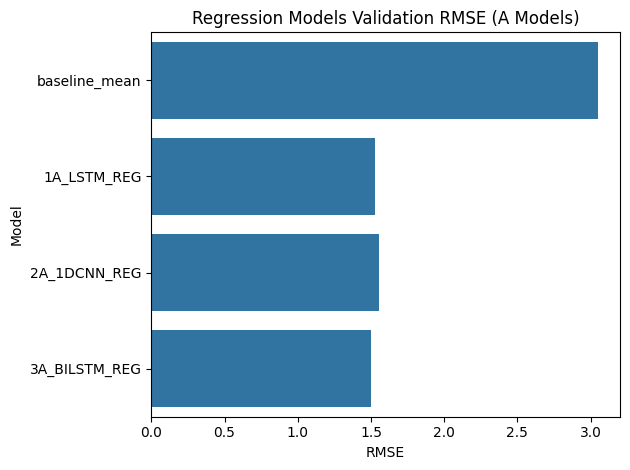

In [91]:
plt.figure()
sns.barplot(data = reg_results_df, x = 'val_rmse', y = 'model', orient = 'h')
plt.title('Regression Models Validation RMSE (A Models)')
plt.xlabel('RMSE')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

Also, showing the results of the validation accuracy below in a graphical form, showing the 3B model slightly edged out the other two. Baseline Majority Class Accuracy is included as well, but it should be noted that this is not a validation score. It is simply included to give a benchmark for comparison to the modeling.

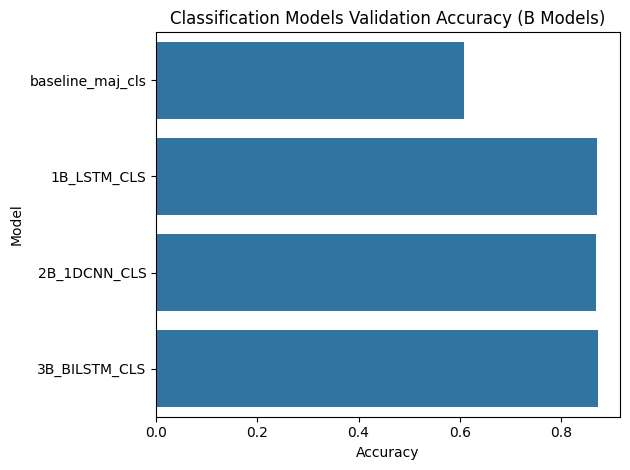

In [92]:
plt.figure()
sns.barplot(data = cls_results_df, x = 'val_acc', y = 'model', orient = 'h')
plt.title('Classification Models Validation Accuracy (B Models)')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

## Example of Best Performing Model in Action on Buoy ID 41008 (Costal Georgia)

Now that the modeling results have been shown, its time to see the model in action with an example buoy below. This plot shows the model's 24 hour ahead predictions for surf score across a 7 day period on this specific buoy. The true surf score is plotted alongside this prediction as well for comparison. As one can see, the model tracks much of the surf scores macro movements across this 7 day period, while some of the micro movements are missed. This is expected due to the amount of noise in the dataset.

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


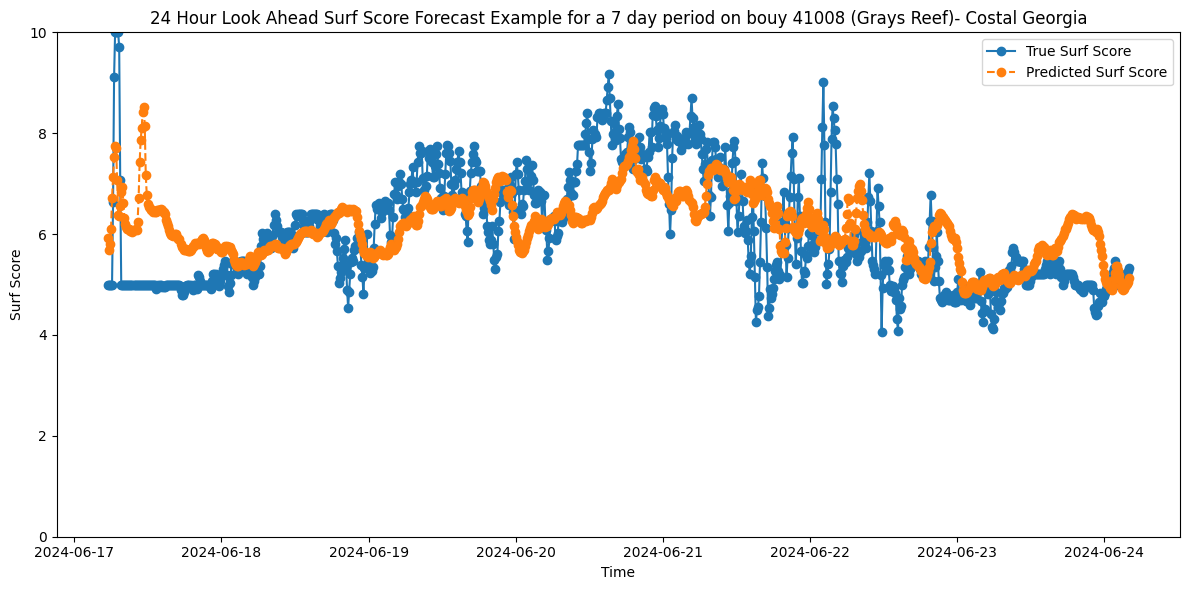

In [93]:
lookback = 24
lookfwd = 24
bouytest = '41008'

df_testb = test_df[test_df['bouy_id']==bouytest].sort_values('datetime').copy()
X_b, y_b = sequencer(df_testb, feat, targ_reg, lookback, lookfwd )

if len(X_b) == 0:
  print('not enough data')
else:
  y_pred_ = best_model.predict(X_b, batch_size = 512).ravel()
  start = lookback + lookfwd - 1
  times = df_testb['datetime'].iloc[start: start + len(y_b)]

  n_plt = min(1000, len(y_b))
  plt.figure(figsize = (12, 6))

  plt.plot(times[:n_plt], y_b[:n_plt], marker = 'o', label = 'True Surf Score')
  plt.plot(times[:n_plt], y_pred_[:n_plt], marker = 'o', linestyle = '--', label = 'Predicted Surf Score')
  plt.xlabel('Time')
  plt.ylabel('Surf Score')
  plt.title('24 Hour Look Ahead Surf Score Forecast Example for a 7 day period on bouy 41008 (Grays Reef)- Costal Georgia')
  plt.legend()
  plt.tight_layout()
  plt.ylim(0, 10)
  plt.show()

This second plot shows the model's 24 hour ahead predictions for surf label, a.k.a surfability, across a 7 day period on this specific buoy. The true surfability is plotted alongside this prediction as well for comparison. As one can see, the model tracks perfectly for this 7 day period, showing the binary class of 1 (surfable) for this specfic buoy and 7 day time window.

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


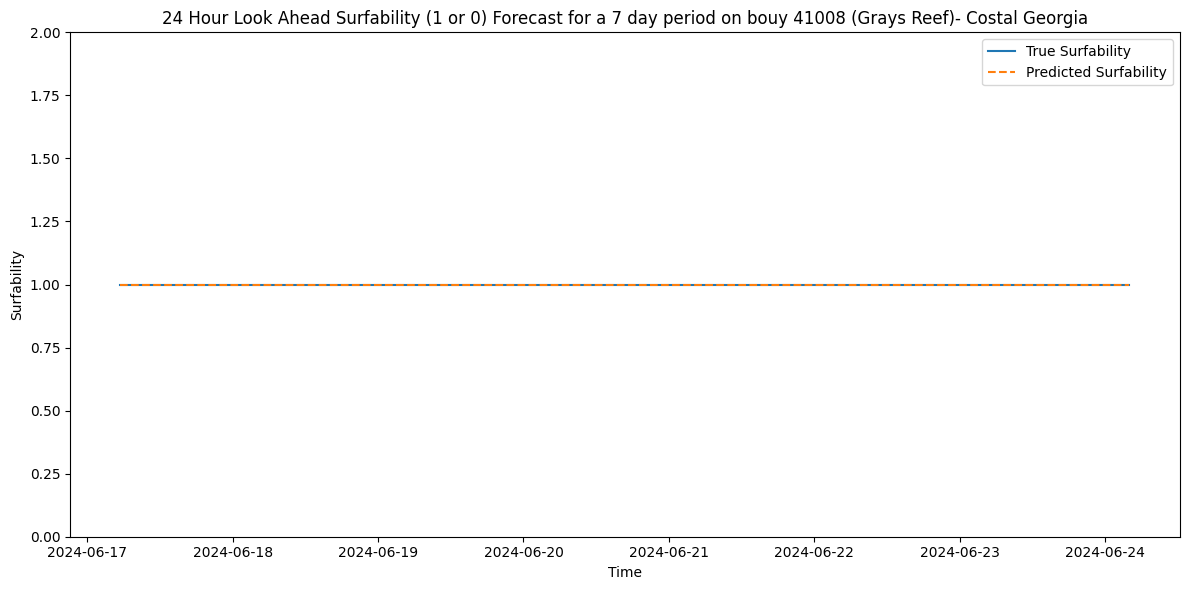

In [94]:
lookback = 24
lookfwd = 24
bouytest = '41008'

df_testb = test_df[test_df['bouy_id']==bouytest].sort_values('datetime').copy()
X_bcls, y_bcls = sequencer_cls(df_testb, feat, targ_cls, lookback, lookfwd )

y_pred_cls = best_cls_model.predict(X_bcls, batch_size = 512)
y_pred_cls = y_pred_cls[:,1]
y_pred_cls = (y_pred_cls>=0.5).astype(int)

start = lookback + lookfwd - 1
times = df_testb['datetime'].iloc[start: start + len(y_bcls)]

n_plt = min(1000, len(y_bcls))
plt.figure(figsize = (12, 6))

plt.plot(times[:n_plt], y_bcls[:n_plt],  label = 'True Surfability')
plt.plot(times[:n_plt], y_pred_cls[:n_plt],  linestyle = '--', label = 'Predicted Surfability')
plt.xlabel('Time')
plt.ylabel('Surfability')
plt.title('24 Hour Look Ahead Surfability (1 or 0) Forecast for a 7 day period on bouy 41008 (Grays Reef)- Costal Georgia')
plt.legend()
plt.tight_layout()
plt.ylim(0, 2)
plt.show()

## 3A and 3B (best performing models) Loss, RMSE, and Accuracy plotted over training Epochs

The below plots show the visual training of the 3A and 3B models (best perfroming models) across all the epochs they were trained. The metrics shown across the different epochs are Loss, RMSE, and Accuracy for 3A and 3B

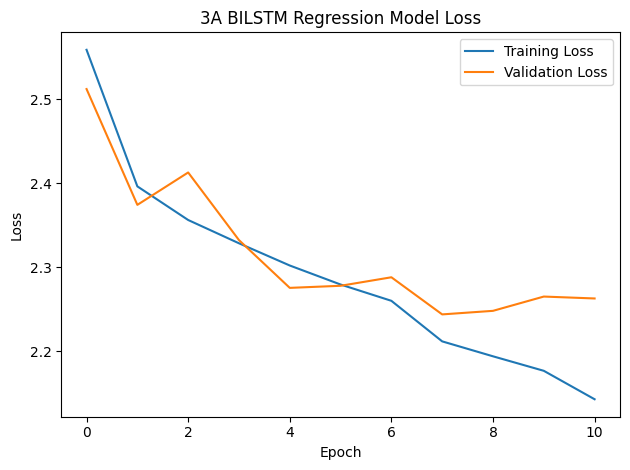

In [96]:
plt.figure()
plt.plot(best_hist['loss'], label = 'Training Loss')
plt.plot(best_hist['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('3A BILSTM Regression Model Loss')
plt.legend()
plt.tight_layout()
plt.show()


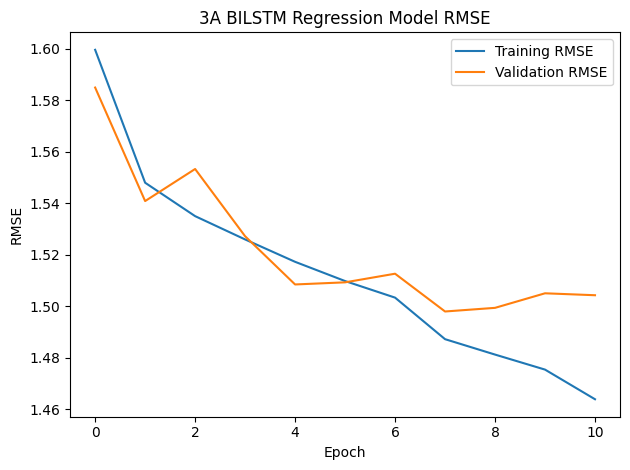

In [97]:
plt.figure()
plt.plot(best_hist['rmse'], label = 'Training RMSE')
plt.plot(best_hist['val_rmse'], label = 'Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('3A BILSTM Regression Model RMSE')
plt.legend()
plt.tight_layout()
plt.show()

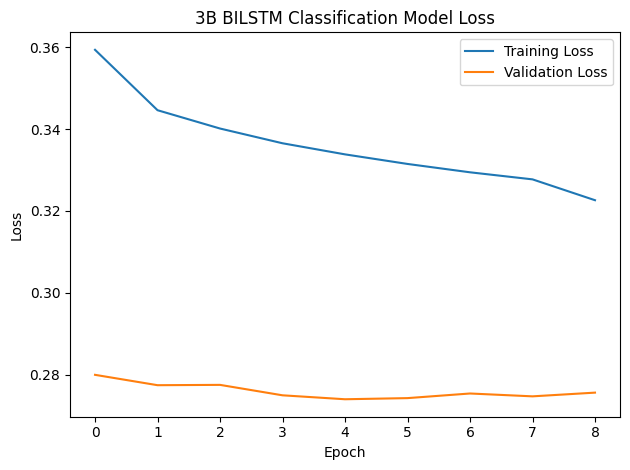

In [98]:
plt.figure()
plt.plot(best_hist_cls['loss'], label = 'Training Loss')
plt.plot(best_hist_cls['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('3B BILSTM Classification Model Loss')
plt.legend()
plt.tight_layout()
plt.show()

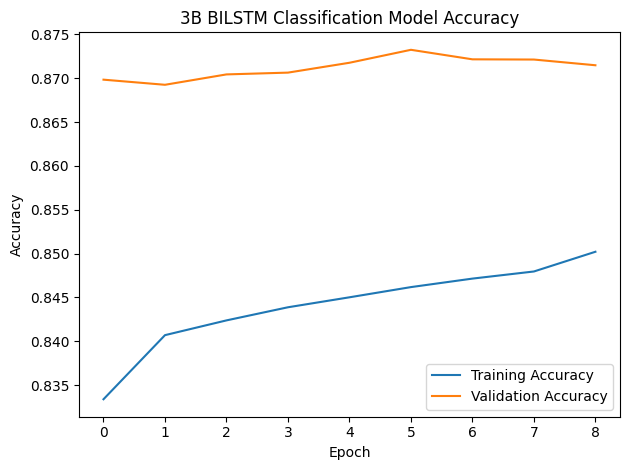

In [99]:
plt.figure()
plt.plot(best_hist_cls['accuracy'], label = 'Training Accuracy')
plt.plot(best_hist_cls['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('3B BILSTM Classification Model Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Discussion and Conclusion

As previously stated in the results section above, the best performing models out of the various runs were the 3A and 3B Bidirectional LSTM regression and classification models. These models yielded a strong result, truly learning from the data and showing a significant increase in efficacy over the mean baseline. The 3A BILSTM Regression model yielded a **1.33** Test RMSE (56% improvement over the baseline), and the 3B BILSTM Classification model yielded a test accuracy of **0.88** (~45% increase over the baseline).

Learnings and Takeaways:

One of the main takeaways from this project was that Deep Learning methodology, such as CNNs and RNNs, can be applied to multivarite time series data with some success. All of the models utilized (LSTM, 1D CNN, and BILSTM) gave a strong result, outperforming the baseline benchmarks in both regression and classification. Additionally, utilizing time sequencing to create sliding windows for CNNs and RNNs to interpret is a valid approach to dealing with time series data.

What Didnt Work & Oppurtunities for Improvment:

One of the drawbacks of the current dataset is that there are a lot of missing values. The data cleansing pipeline in this notebook did a good job of imputing these values, but it would be nice to have a clean dataset, with no missing values where buoy telemetry is missing. In future modeling runs, it may be useful to only filter to specific buoys that have near 100% data completeness, rather than backfill and forward fill the missing values.

An additional constraint on the existing modeling approach is dropping the use of wind direction in determining surf score and surf label. Wind direction is an important feature in determining the surfability of waves. Offshore wind typically leads to clean surf, whereas onshore wind typically leads to messier surf that is not as surfable for most individuals. As it was virtually impossible within the scope of this project to identify the location of all buoys relative to their closest shoreline, identifying whether wind was "offshore" or "onshore" based on this data was not feasible. Perhaps in future attemps, this will be a feature that will be creatively dealth with.

Future Applications of this Modeling:

Further applications of this modeling could be the creation of a web based application that gives surfers a 24 hour look-ahead forecast, very simply providing them with the "GO or NO GO" directive for surfing in the next 24 hour window. With existing surf forecasting apps, it is too easy to get bogged down in the details of whether or not to go surf based on the current conditions. The simplicity of the surf-label, giving the user a clear directive of to surf or not to surf is what makes this modeling unique and differentiates it from other surf forecasting tools out there.

# Citations



[1] National Data Buoy Center. (1971–2025). Standard Meteorological (stdmet) historical buoy data. NOAA.https://www.ndbc.noaa.gov/data/historical/stdmet/

[2] Brownlee, J. (2018). How to develop LSTM models for time-series forecasting. Machine Learning Mastery. Retrieved , from https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

[3] Minuzzi, F. C., & Farina, L. (2023). A deep learning approach to predict significant wave height using long short-term memory. Ocean Modelling, 181, 102151. https://www.sciencedirect.com/science/article/pii/S1463500322001652

[4] OpenAI. (2025). ChatGPT (version GPT-5) [Large language model]. OpenAI. (Used for error trace debugging and function usage examples.)

[5] Google DeepMind. (2025). Gemini [Large language model]. Google DeepMind. (Used for error trace debugging and function usage examples.)

[6] S. Hans. (2021). LSTM Networks | A Detailed Explanation. Towards Data Science. https://towardsdatascience.com/lstm-networks-a-detailed-explanation-8fae6aefc7f9/

[7] Schmidt, L. (2021, April 30). Time series classification with convolutions. Medium – Analytics Vidhya. Retrieved , from https://medium.com/analytics-vidhya/time-series-classification-with-convolutions-ed5cb33b1e3b



# Appendix: Data Engineering

## Identifying all active NOOA stations

In [2]:
def active_nbdc():
  url = 'https://www.ndbc.noaa.gov/activestations.xml'
  resp = requests.get(url)
  rt = ET.fromstring(resp.content)

  rows = []
  for station in rt.findall('station'):
    rows.append({'id': station.attrib.get('id'), 'name': station.attrib.get('name'),
                 'lat': station.attrib.get('lat'), 'lon': station.attrib.get('lon'),
                 'owner': station.attrib.get('owner'),
                 'pgm': station.attrib.get('pgm'), 'met': station.attrib.get('met'),
                 'type': station.attrib.get('type'), 'currents': station.attrib.get('currents'),
                 'waterquality': station.attrib.get('waterquality'),
                 })
  return pd.DataFrame(rows)



In [3]:
stations_df = active_nbdc()
stations_df.head()

,id,name,lat,lon,owner,pgm,met,type,currents,waterquality
0,0y2w3,"Sturgeon Bay CG Station, WI",44.794,-87.313,U.S.C.G. Marine Reporting Stations,IOOS Partners,n,fixed,n,n
1,13001,NE Extension,12,-23,Prediction and Research Moored Array in the At...,International Partners,n,buoy,n,n
2,13002,NE Extension,21,-23,Prediction and Research Moored Array in the At...,International Partners,y,buoy,n,n
3,13008,Reggae,15,-38,Prediction and Research Moored Array in the At...,International Partners,y,buoy,n,n
4,13009,Lambada,8,-38,Prediction and Research Moored Array in the At...,International Partners,n,buoy,n,n


In [4]:
stations_df.describe()

,id,name,lat,lon,owner,pgm,met,type,currents,waterquality
count,1364,1364,1364,1364,1364,1364,1318,1364,1318,1318
unique,1364,1317,1249,1251,93,8,2,7,2,2
top,zbqn7,,0,-170,NDBC,IOOS Partners,y,fixed,n,n
freq,1,35,15,9,232,518,813,718,1277,1198


## Filtering for stations that have data on wave height

In [5]:
def wave_data(station_id: str):
  url = f'https://www.ndbc.noaa.gov/data/realtime2/{station_id}.txt'

  try:
    r = requests.get(url, timeout=10)
    if r.status_code != 200:
      return None

    line = r.text.splitlines()
    data_line = [x for x in line if x.startswith('#')]
    if not data_line:
      return False

    head = data_line[0].lstrip('#').split()
    return 'WVHT' in head

  except Exception:
    return False

In [6]:
wve_ids = []
for sid in tqdm(stations_df['id'], desc = 'wave data check'):
  if wave_data(sid):
    wve_ids.append(sid)

wave data check: 100%|██████████| 1364/1364 [03:12<00:00,  7.07it/s]


In [7]:
len(wve_ids), wve_ids[:10]

(336,
 ['13002',
  '13008',
  '14049',
  '15001',
  '15002',
  '15006',
  '15009',
  '23003',
  '23008',
  '23009'])

In [9]:
wave_df = stations_df[stations_df['id'].isin(wve_ids)].reset_index(drop=True)
wave_df.head()

,id,name,lat,lon,owner,pgm,met,type,currents,waterquality
0,13002,NE Extension,21,-23,Prediction and Research Moored Array in the At...,International Partners,y,buoy,n,n
1,13008,Reggae,15,-38,Prediction and Research Moored Array in the At...,International Partners,y,buoy,n,n
2,14049,,-12,65,Research Moored Array for African-Asian-Austra...,International Partners,y,buoy,n,n
3,15001,Gavotte,-10,-10,Prediction and Research Moored Array in the At...,International Partners,y,buoy,n,n
4,15002,Java,0,-10,Prediction and Research Moored Array in the At...,International Partners,y,buoy,n,n


In [10]:
wave_df.shape

(336, 10)

## Defining Buoy data

In [11]:
def bouys(bouy_id: str, year: int):
  url = f'https://www.ndbc.noaa.gov/data/historical/stdmet/{bouy_id}h{year}.txt.gz'
  try:
    r = requests.get(url, timeout=20)
    if r.status_code != 200:
      return None
    text = gzip.decompress(r.content).decode('utf-8', errors = 'ignore')

  except Exception:
    return None

  line = text.splitlines()
  if not line:
    return None

  headline = [x for x in line if x.startswith('#')]
  dataline = [x for x in line if not x.startswith('#')]

  if not headline or not dataline:
    return None

  head = headline[0].lstrip('#').split()

  cleaned = '\n'.join([' '.join(head)] + dataline)

  df = pd.read_csv(StringIO(cleaned), sep = r'\s+')

  req = ['YY', 'MM', 'DD', 'hh', 'mm']
  if not all(col in df.columns for col in req):
    return None

  try:
    dt_df = df[req].rename(columns={'YY': 'year', 'MM': 'month', 'DD': 'day',
                                    'hh': 'hour', 'mm': 'minute'})
    df['datetime'] = pd.to_datetime(dt_df)

  except Exception:
    return None

  sent_values= {99, 999, 9999, 99.0, 999.0, 9999.0, 99.00, 999.00, 9999.00}

  for col in df.columns:
    if col not in ['datetime', 'YY']:
      df[col] = pd.to_numeric(df[col], errors='coerce')
      df[col] = df[col].replace(sent_values, np.nan)

  df['bouy_id'] = bouy_id
  df = df.sort_values('datetime').reset_index(drop=True)

  return df




In [12]:
df_test = bouys('46218', 2019)
df_test[['datetime', 'YY', 'MM', 'DD', 'hh', 'mm', 'WVHT', 'DPD', 'APD', 'MWD']].head()

,datetime,YY,MM,DD,hh,mm,WVHT,DPD,APD,MWD
0,2019-01-01 00:00:00,2019,1,1,0,0,3.25,11.11,8.37,316.0
1,2019-01-01 00:30:00,2019,1,1,0,30,3.24,9.88,8.23,310.0
2,2019-01-01 01:00:00,2019,1,1,1,0,3.04,10.53,8.18,320.0
3,2019-01-01 01:30:00,2019,1,1,1,30,2.97,10.53,7.93,307.0
4,2019-01-01 02:00:00,2019,1,1,2,0,3.06,11.11,7.97,316.0


## Pulling in Historical bouy Data

In [13]:
def bouy_hist(bouy_id: str, start_year: int = 2019, end_year: int = 2024):
  dfs = []
  for year in range(start_year, end_year + 1):
    df_yr = bouys(bouy_id, year)
    if df_yr is not None and not df_yr.empty:
      dfs.append(df_yr)

  if not dfs:
    return None
  df_all = pd.concat(dfs, ignore_index=True)
  df_all['bouy_id'] = bouy_id
  return df_all


In [14]:
test_id = '46218'
df_test = bouy_hist(test_id, 2019, 2024)
df_test.head()

,YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE,datetime,buoy_id
0,2019,1,1,0,0,NaN,NaN,NaN,3.25,11.11,8.37,316.0,NaN,NaN,13.4,NaN,NaN,NaN,2019-01-01 00:00:00,46218
1,2019,1,1,0,30,NaN,NaN,NaN,3.24,9.88,8.23,310.0,NaN,NaN,13.4,NaN,NaN,NaN,2019-01-01 00:30:00,46218
2,2019,1,1,1,0,NaN,NaN,NaN,3.04,10.53,8.18,320.0,NaN,NaN,13.4,NaN,NaN,NaN,2019-01-01 01:00:00,46218
3,2019,1,1,1,30,NaN,NaN,NaN,2.97,10.53,7.93,307.0,NaN,NaN,13.5,NaN,NaN,NaN,2019-01-01 01:30:00,46218
4,2019,1,1,2,0,NaN,NaN,NaN,3.06,11.11,7.97,316.0,NaN,NaN,13.4,NaN,NaN,NaN,2019-01-01 02:00:00,46218


In [15]:
df_test.shape

(103954, 20)

In [16]:
all_df = []
fail_id = []

for i in tqdm(wve_ids, desc = 'Getting historical bouy data from 2019 to 2024'):
  df_bouy = bouy_hist(i, 2019, 2024)
  if df_bouy is None or df_bouy.empty:
    fail_id.append(i)
    continue

  all_df.append(df_bouy)


Getting historical buoy data from 2019 to 2024: 100%|██████████| 336/336 [11:23<00:00,  2.03s/it]


In [17]:
len(all_df), len(fail_id)

(236, 100)

In [18]:
gc.collect()

0

In [19]:
df_total = pd.concat(all_df, ignore_index=True)
df_total = df_total.sort_values(['bouy_id','datetime']).reset_index(drop=True)
df_total.head(), df_total.shape

(     YY  MM  DD  hh  mm  WDIR  WSPD  GST  WVHT  DPD  APD  MWD    PRES  ATMP  \
 0  2019   5   1  18  40  76.0   0.1  1.2   NaN  NaN  NaN  NaN  1029.0  25.8   
 1  2019   5   1  18  50  57.0   0.1  0.8   NaN  NaN  NaN  NaN  1028.9  25.7   
 2  2019   5   1  19   0  65.0   0.1  1.2   NaN  NaN  NaN  NaN  1029.0  25.5   
 3  2019   5   1  19  10  69.0   0.1  0.7   NaN  NaN  NaN  NaN  1028.9  25.8   
 4  2019   5   1  19  20  64.0   0.1  1.3   NaN  NaN  NaN  NaN  1028.7  25.9   
 
    WTMP  DEWP  VIS  TIDE            datetime buoy_id  
 0   NaN  18.1  NaN   NaN 2019-05-01 18:40:00   41001  
 1   NaN  18.1  NaN   NaN 2019-05-01 18:50:00   41001  
 2   NaN  18.2  NaN   NaN 2019-05-01 19:00:00   41001  
 3   NaN  18.3  NaN   NaN 2019-05-01 19:10:00   41001  
 4   NaN  18.3  NaN   NaN 2019-05-01 19:20:00   41001  ,
 (33022209, 20))

In [20]:
metadata = ['id', 'name', 'lat', 'lon', 'owner', 'type']
wvemeta = wave_df[metadata].rename(columns={'id': 'bouy_id'})

df_all = df_total.merge(wvemeta, on='bouy_id', how='left')
df_all.head()

,YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,...,DEWP,VIS,TIDE,datetime,buoy_id,name,lat,lon,owner,type
0,2019,5,1,18,40,76.0,0.1,1.2,NaN,NaN,...,18.1,NaN,NaN,2019-05-01 18:40:00,41001,EAST HATTERAS - 150 NM East of Cape Hatteras,34.791,-72.42,NDBC,other
1,2019,5,1,18,50,57.0,0.1,0.8,NaN,NaN,...,18.1,NaN,NaN,2019-05-01 18:50:00,41001,EAST HATTERAS - 150 NM East of Cape Hatteras,34.791,-72.42,NDBC,other
2,2019,5,1,19,0,65.0,0.1,1.2,NaN,NaN,...,18.2,NaN,NaN,2019-05-01 19:00:00,41001,EAST HATTERAS - 150 NM East of Cape Hatteras,34.791,-72.42,NDBC,other
3,2019,5,1,19,10,69.0,0.1,0.7,NaN,NaN,...,18.3,NaN,NaN,2019-05-01 19:10:00,41001,EAST HATTERAS - 150 NM East of Cape Hatteras,34.791,-72.42,NDBC,other
4,2019,5,1,19,20,64.0,0.1,1.3,NaN,NaN,...,18.3,NaN,NaN,2019-05-01 19:20:00,41001,EAST HATTERAS - 150 NM East of Cape Hatteras,34.791,-72.42,NDBC,other


In [ ]:
# df_all.to_csv('bouy_data.csv', index=False)

# pd.series(failed_ids, name = 'failed_ids').to_csv('failed_ids.csv', index=False)

## Saving data to drive in parquet form

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
df_all.to_parquet('/content/drive/MyDrive/dl_Final/bouy_data.parquet', index = False)
pd.Series(fail_id, name = 'failed_ids').to_csv('/content/drive/MyDrive/dl_Final/failed_ids.csv', index = False)
















 test




















 test
